### HW 3-1. DQN for Traffic Light Control

Please write down the codes for DQN algorithm on this file. Also, add your comment with the result here,

In [1]:
### DQN ###
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple


Transition=namedtuple('Transition',('state','action','reward','next_state','done'))

class ReplayMemory(object):
    
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    def push(self, *args):
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.position]=Transition(*args)
        self.position=(self.position+1)% self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class QNetwork(nn.Module):
    def __init__(self, state_dim,action_dim,hidden_dim=32):
        super(QNetwork,self).__init__()
        self.lin1=nn.Linear(state_dim,hidden_dim)
        self.lin2=nn.Linear(hidden_dim,action_dim)
        
    def forward(self,x):
        x=F.relu(self.lin1(x))
        x=self.lin2(x)
        return x
    
class DQNAgent(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(DQNAgent,self).__init__()
        self.action_dim=action_dim
        
        self.QNet=QNetwork(state_dim,action_dim)
        self.target_Qnet=QNetwork(state_dim,action_dim)
        self.target_Qnet.load_state_dict(self.QNet.state_dict())
        
        self.optimizer=torch.optim.Adam(self.QNet.parameters(),lr=1e-3)
        
        self.memory=ReplayMemory(5000)
        
        self.gamma=0.999
        self.epsilon=0.99
        self.epsilon_min=0.01
        self.epsilon_decay=0.9995
        
        self.batch_size=50
        
        self.num_fit=0
        
    def forward(self,state):
        return self.QNet(state)
    
    def train_start(self):
        
        if len(self.memory) > self.batch_size:
            return True
        else:
            return False
    
    def save_memory(self,transition):
        self.memory.push(transition[0],transition[1],transition[2],transition[3],transition[4])
        
    def train(self):

        self.num_fit += 1
        
        sample= self.memory.sample(self.batch_size)
        
        before_state=[i[0] for i in sample]
        action=[i[1] for i in sample]
        reward=[i[2] for i in sample]
        state=[i[3] for i in sample]
        done=[i[4] for i in sample]
        
        before_state=np.stack(before_state)
        before_state_batch=torch.tensor(before_state).squeeze(-2)
        ##print(before_state_batch.shape)
        
        action=np.array(action)
        action_batch=torch.tensor(action, dtype=int).unsqueeze(-1)
        ##print(action_batch.shape)
        state=np.stack(state)
        state_batch=torch.tensor(state).squeeze(-2)
        ##print(state_batch.shape)
        reward=np.array(reward)
        reward_batch=torch.tensor(reward,dtype=torch.float32).reshape(-1,1)
        ##print(reward_batch.shape)
        done = np.array(done).astype(int)
        done_batch=torch.tensor(done).reshape(-1,1)
        ##print(done_batch.shape)
        qs=self.QNet(before_state_batch).gather(1, action_batch)

        with torch.no_grad():
            q_max, _= self.target_Qnet(state_batch).max(dim=-1, keepdims=True)
            q_target=reward_batch + self.gamma * q_max * ( 1-done_batch)
            

        loss=F.smooth_l1_loss(qs,q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.num_fit % 100 == 0 :
            self.target_Qnet.load_state_dict(self.QNet.state_dict())
            
        return loss.item()


1 -644
2 -523
3 -860
4 -374
5 -429
6 -470
7 -495
8 -651
9 -408
10 -424
11 -462
12 -808
13 -623
14 -450
15 -487
16 -348
17 -343
18 -432
19 -436
20 -393
21 -516
22 -376
23 -521
24 -611
25 -582
26 -384
27 -346
28 -487
29 -686
30 -388
31 -392
32 -570
33 -447
34 -597
35 -406
36 -323
37 -405
38 -319
39 -482
40 -369
41 -447
42 -453
43 -348
44 -450
45 -485
46 -504
47 -375
48 -391
49 -409
50 -455
51 -467
52 -586
53 -297
54 -390
55 -376
56 -331
57 -508
58 -370
59 -339
60 -310
61 -433
62 -480
63 -426
64 -409
65 -384
66 -488
67 -409
68 -423
69 -354
70 -286
71 -401
72 -443
73 -328
74 -347
75 -537
76 -389
77 -454
78 -340
79 -398
80 -298
81 -303
82 -445
83 -386
84 -453
85 -486
86 -359
87 -303
88 -284
89 -397
90 -353
91 -345
92 -381
93 -270
94 -323
95 -345
96 -421
97 -307
98 -318
99 -328
100 -485
101 -330
102 -456
103 -373
104 -339
105 -345
106 -313
107 -481
108 -387
109 -483
110 -344
111 -343
112 -398
113 -374
114 -346
115 -338
116 -423
117 -507
118 -364
119 -351
120 -492
121 -347
122 -370
123 -340
1

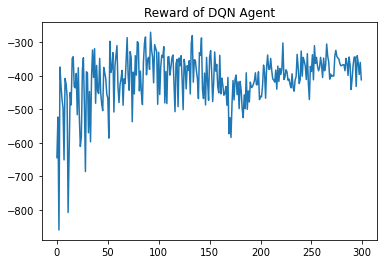

In [2]:
### Training (Do not revise this code) ###
from SUMO.TrafficEnv_DQN import TrafficEnv

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

def main_DQN() :

    exp_dir = './SUMO/Single_Intersection'
    exp_type = 'binary'

    max_episode = 300
    max_epi_step = 800

    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    state_dim = 12
    action_dim = 2

    env = TrafficEnv(exp_dir, exp_type)
    agent = DQNAgent(state_dim, action_dim)

    loss_list = []
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        loss_epi = []
        reward_epi = []
        action = None

        for epi_step in range(max_epi_step):

            # make an action based on epsilon greedy action
            before_action = action

            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                action = agent(state)
                action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                loss = agent.train()
                loss_epi.append(loss)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        if agent.train_start():
            loss_list.append(sum(loss_epi)/len(loss_epi))

        env.close()
        reward_list.append(sum(reward_epi))

        print(episode+1, reward_list[-1])

    return loss_list, reward_list


if __name__ == "__main__":

    loss_list, reward_list = main_DQN()

    plt.plot(loss_list)
    plt.title("Loss of DQN Agent")
    plt.savefig("./Visualization/DQN/loss.png")
    plt.close('all')

    plt.plot(reward_list)
    plt.title("Reward of DQN Agent")
    plt.savefig("./Visualization/DQN/reward.png")
    plt.show()
    plt.close('all')

In [ ]:
### Add your comment for the result here###
Reward가 크게 fluctuate한다. Loss는 증가와 감소가 반복된다.
-300~-400 근처로 수렴함을 볼 수 있다.
Hyperparameter tuning 을 하면 더 좋은 학습을 할 수 있을 것이다. 